<a href="https://colab.research.google.com/github/soroushmirzaei/text-processing-projects/blob/main/imdb-reviews-text-classification/imdb-reviews-text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirement libraries
import os
import shutil

#import dataset query libraries
import csv
import json

#import mathematics statics libraries
import random as rnd
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras


In [ ]:
#download stop-words dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/english-language-stop-words.txt
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-stop-words.txt

#download filters-characters dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/english-language-filter-characters.txt
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-filter-characters.txt

#download similar-characters dataset
!wget -q https://raw.githubusercontent.com/soroushmirzaei/text-processing-projects/main/persian-language-similar-characters.json


In [ ]:
#define filters-list function loader
def filter_chars(file_path):
    filter_chars = list()
    with open(file_path, 'r') as filters_list_file:
        for word in filters_list_file:
            filter_chars.append(word.strip('\n'))
        filters_list_file.close()
    return filter_chars

#define stop-words function loader
def stop_word(file_path):
    stop_words = list()
    with open(file_path, 'r') as stop_words_file:
        for word in stop_words_file:
            stop_words.append(word.strip('\n'))
        stop_words_file.close()
    return stop_words

#define similar-characters function loader
def similar_chars(file_path):
    with open(file_path, 'r') as similar_chars_file:
        similar_chars = json.load(similar_chars_file)
    return similar_chars


In [ ]:
#load stop-words
eng_stop_words = stop_word('english-language-stop-words.txt')
per_stop_words = stop_word('persian-language-stop-words.txt')

#load filters-characters
eng_filter_characters = filter_chars('english-language-filter-characters.txt')
per_filter_characters = filter_chars('persian-language-filter-characters.txt')

#load similar-characters
per_similar_characters = similar_chars('persian-language-similar-characters.json')


In [ ]:
#define remove filters characters function
def remove_filter(text, filters_list):
    characters = list(text)
    characters_without_filters = [character for character in characters if character not in filters_list]
    text_without_filters = ''.join(characters_without_filters)
    return text_without_filters

#define remove texts stopwords function
def remove_stopword(text, stop_words_list):
    text = text.lower()
    words_with_stopwords = text.split(' ')
    words_without_stopwords = [word for word in words_with_stopwords if word not in stop_words_list]
    text_without_stopwords = ' '.join(words_without_stopwords)
    return text_without_stopwords

#define similar characters modification function
def similar_char(text, similar_chars_dict):
    characters = list(text)
    similar_characters_modified_list = [similar_chars_dict.get(character,character) for character in characters]
    similar_characters_modified_text = ''.join(similar_characters_modified_list)
    return similar_characters_modified_text


In [ ]:
#load dataset
data, info = tfds.load('imdb_reviews', as_supervised = True, with_info = True)


In [ ]:
#print out dataset info
info


tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [ ]:
#define tensorflow text labels loader
def tfds_texts_labels_lodaer(#define data and keyword
                             data, key,
                             ):
    
    #define empty texts labels list
    texts_list = list()
    labels_list = list()

    #iterate over data by key to split texts labels
    for text, label in data[key]:
        texts_list.append(text.numpy().decode('utf8'))
        labels_list.append(label.numpy())

    return texts_list, labels_list


In [ ]:
train_texts_list, train_labels_list = tfds_texts_labels_lodaer(data, 'train')
valid_texts_list, valid_labels_list = tfds_texts_labels_lodaer(data, 'test')


In [ ]:
#define labels encoder
def label_encoder(#define labels list and method
                  labels_list,
                  #define method binary, ordinal or onehot
                  method, return_categories = True
                  ):
    
    #ordinal and binary encoder method
    if method in ['binary','ordinal']:
        unique_labels = sorted(list(set(labels_list)))
        labels_dict = {
            label : int(unique_labels.index(label)) for label in unique_labels
        }
        labels = list(map(lambda label : labels_dict[label], labels_list))
    
    #one-hot encoder method
    elif method in ['onehot']:
        unique_labels = sorted(list(set(labels_list)))
        labels_dict = {
            label : int(unique_labels.index(label)) for label in unique_labels
        }
        labels_encoded = list()
        for label in labels_list:
            label_encoded = len(unique_labels)*[0]
            label_number = labels_dict[label]
            label_encoded[label_number] = 1
            labels_encoded.append(label_encoded)
        labels = labels_encoded

    #convert list type to array
    labels_encoded = np.array(labels)
    
    if return_categories:
        return labels_encoded, labels_dict
    else:
        return labels_encoded
        

In [ ]:
train_labels_encoded, train_labels_dict = label_encoder(train_labels_list, 'ordinal')
valid_labels_encoded, valid_labels_dict = label_encoder(valid_labels_list, 'ordinal')


In [ ]:
#define tokenizer and sequences and padding sequences
def pad_sequences(#define training and validation set
                  train_texts, valid_texts,
                  #define vocab size and out of vocab word
                  vocab_size = None, oov_word = None,
                  #define filter characters list
                  use_modified_filters = False, filters_list = None,
                  #define sequence length, padding and truncating
                  sequence_len = None, padding_point = 'post', truncating_point = 'post',
                  #define json tokenizer
                  save_tokenizer_json = False, tokenizer_filepath = None
                  ):
    
    #define tokenizer and fit
    from keras.preprocessing.text import Tokenizer
    if use_modified_filters:
        filters = ''.join(filters_list)
    else:
        filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_word,
                          filters = filters)
    tokenizer.fit_on_texts(train_texts)
    word_index = tokenizer.word_index

    if save_tokenizer_json:
        with open(tokenizer_filepath+'.json','w') as tokenizer_file:
            json.dump(tokenizer.to_json(), tokenizer_file)

    #define training validation texts to sequences
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    valid_sequences = tokenizer.texts_to_sequences(valid_texts)

    #define training validation pad sequences
    from keras.preprocessing.sequence import pad_sequences
    train_padded_sequences = pad_sequences(train_sequences, maxlen = sequence_len,
                                           padding = padding_point, truncating = truncating_point)
    valid_padded_sequences = pad_sequences(valid_sequences, maxlen = sequence_len,
                                           padding = padding_point, truncating = truncating_point)

    return train_padded_sequences, valid_padded_sequences, tokenizer, word_index


In [ ]:
train_padded_sequences, valid_padded_sequences, tokenizer, word_index = pad_sequences(#define training and validation set
                                                                                      train_texts_list, valid_texts_list,
                                                                                      #define vocab size and out of vocab word
                                                                                      vocab_size = None, oov_word = '<oov>',
                                                                                      #define filter characters list
                                                                                      use_modified_filters = False, filters_list = None,
                                                                                      #define sequence length, padding and truncating
                                                                                      sequence_len = 75)

In [ ]:
#load pre-trained word vectors
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

#unzip the loaded file
!unzip -q crawl-300d-2M.vec.zip


--2022-06-30 17:31:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  11.8MB/s    in 2m 56s  

2022-06-30 17:33:59 (8.27 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [ ]:
#define pre-trained words dictionary loader
def word_dict_loader(#define file path and file type
                     file_path, file_type,
                     #define txt and csv file type args
                     word_index = None, vector_index = None, header = True, spliter_delimiter = None,
                     use_word_spliter = False, word_spliter = None, word_split_index = None,
                     #define json file type args
                     word_key = None, vector_key = None,
                     ):
    
    word_dict = dict()

    #define txt vec loader
    if file_type in ['txt', 'vec']:
        with open(file_path, 'r') as word_dict_file:
            if header:
                next(word_dict_file)
            for row in word_dict_file:
                row = row.split(spliter_delimiter)
                if use_word_spliter:
                    word = row[word_index].split(word_spliter)[word_split_index]
                else:
                    word = row[word_index]
                vectors = np.array(row[vector_index:], dtype = 'float32')
                word_dict[word] = vectors

    #define csv loader
    elif file_type in ['csv']:
        with open(file_path, 'r') as word_dict_file:
            word_dict_file = csv.reader(word_dict_file, delimiter = spliter_delimiter)
            if header:
                next(word_dict_file)
            for row in word_dict_file:
                if use_word_spliter:
                    word = row[word_index].split(word_spliter)[word_split_index]
                else:
                    word = row[word_index]
                vectors = np.array(row[vector_index:], dtype = 'float32')
                word_dict[word] = vectors
                
    #define json loader
    elif file_type in ['json']:
        with open(file_path, 'r') as word_dict_file:
            word_dict_file = json.load(word_dict_file)
            for item in word_dict_file:
                word = item[word_key]
                vectors = np.array(item[vector_key], dtype = 'float32')
                word_dict[word] = vectors

    #word dict params
    word_dict_size = len(word_dict)
    word_dict_dim = list(word_dict.values())[0].shape[0]

    return word_dict, word_dict_size, word_dict_dim


In [ ]:
word_dict, word_dict_size, word_dict_dim = word_dict_loader(#define file path and file type
                                                            file_path = '/content/crawl-300d-2M.vec', file_type = 'vec',
                                                            #define txt and csv file type args
                                                            word_index = 0, vector_index = 1, header = True, spliter_delimiter = ' ')


In [ ]:
#define pre-trained embedding word vectors
def embd_weights_loader(#define word dictionary and word index
                        word_dict, word_index, dimension
                        ):
    
    #create embedding weights
    embed_weights = np.zeros([len(word_index)+1, dimension], dtype = 'float32')

    counter = 0
    for word, index in word_index.items():
        if word in word_dict:
            embed_weights[index] = word_dict[word]
            counter += 1

    #embedding layer params
    vocab_size = embed_weights.shape[0]
    embed_dim = embed_weights.shape[1]

    return embed_weights, vocab_size, embed_dim, counter


In [ ]:
embed_weights, vocab_size, embed_dim, counter = embd_weights_loader(#define word dictionary and word index
                                                                    word_dict = word_dict, word_index = word_index,
                                                                    dimension = word_dict_dim)


In [ ]:
#define how many words the pre-trained will cover
print(f'the tokenizer word index derive {len(word_index)} words\nthe pre-traind word vectors covers {counter} words'.title())


The Tokenizer Word Index Derive 88583 Words
The Pre-Traind Word Vectors Covers 60479 Words


In [ ]:
#define model
def create_model(#define input shape
                 input_shape = None,
                 #define embedding layer parameters
                 use_pretraind_embd = False, vocab_size = None, embd_dim = None,
                 sequence_len = None, embed_weights = None,
                 #define type of layer and parameters
                 use_lstm = False, use_gru = False, use_conv = False,
                 #define lstm layers parameters
                 lstm_layers_num = None, lstm_layers_units = None,
                 #define gru layers parameters
                 gru_layers_num = None, gru_layers_units = None,
                 #define convolution layers parameters
                 conv_layers_num = None, conv_layers_filters = None, conv_layers_kernel = None,
                 #define convolution layers sub layers
                 use_max_pool = False, max_pool_size = None,
                 #define dense layer feeder
                 use_global_max_pool = False, use_global_avg_pool = False, use_flatten = False,
                 use_feeder_dropout = False, feeder_dropout_ratio = None,
                 #define dense head layers
                 use_dense_layers = True, dense_layers_num = None, dense_layers_units = None,
                 #define dense layers dropout parameters
                 use_dense_dropout = False, dense_dropout_ratio = None,
                 #define output layer parameters
                 output_layer_unit = None, output_layer_activation = None,
                 #define model compiler parameters
                 optimizer = None, loss = None, metrics = None
                 ):
    
    #define input layer
    input = keras.Input(shape = input_shape)

    #define embedding layer and parameters
    if use_pretraind_embd:
        out = keras.layers.Embedding(input_dim = vocab_size, output_dim = embd_dim, input_length = sequence_len,
                                     weights = [embed_weights], trainable = False)(input)
    else:
        out = keras.layers.Embedding(input_dim = vocab_size, output_dim = embd_dim, input_length = sequence_len)(input)

    #define type of layer and parameters
    #lstm type layers
    if use_lstm:
        sequence_return = (lstm_layers_num - 1)*[True]
        sequence_return.append(False)
        for layer_num in range(lstm_layers_num):
            out = keras.layers.Bidirectional(keras.layers.LSTM(lstm_layers_units[layer_num],
                                                               return_sequences = sequence_return[layer_num]))(out)

    #gru type layers
    elif use_gru:
        sequence_return = (gru_layers_num - 1)*[True]
        sequence_return.append(False)
        for layer_num in range(gru_layers_num):
            out = keras.layers.Bidirectional(keras.layers.GRU(gru_layers_units[layer_num],
                                                              return_sequences = sequence_return[layer_num]))(out)
    
    #convolution type layer
    elif use_conv:
        for layer_num in range(conv_layers_num):
            out = keras.layers.Conv1D(filters = conv_layers_filters[layer_num], kernel_size = conv_layers_kernel[layer_num],
                                      activation = 'relu')(out)
            if use_max_pool[layer_num]:
                out = keras.layers.MaxPool1D(max_pool_size[layer_num])(out)


    #dense layers feeder layer
    #global max pool type layer
    if use_global_max_pool:
        out = keras.layers.GlobalMaxPooling1D()(out)
        
    #global average pool type layer
    elif use_global_avg_pool:
        out = keras.layers.GlobalAveragePooling1D()(out)

    #flatten type layer
    elif use_flatten:
        out = keras.layers.Flatten()(out)

    #define feeder dropout layer
    if use_feeder_dropout:
        out = keras.layers.Dropout(feeder_dropout_ratio)(out)


    #define dense head layers
    if use_dense_layers:
        for layer_num in range(dense_layers_num):
            out = keras.layers.Dense(dense_layers_units[layer_num], activation = 'relu')(out)
            if use_dense_dropout[layer_num]:
                out = keras.layers.Dropout(dense_dropout_ratio[layer_num])(out)
    
    #define output layer
    output = keras.layers.Dense(output_layer_unit, activation = output_layer_activation)(out)

    #define model
    model = keras.models.Model(inputs = input, outputs = output)


    #compile model
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)
    
    return model
    

In [ ]:
#create model
model = create_model(#define input shape
                     input_shape = 75,
                     #define embedding layer parameters
                     use_pretraind_embd = True, vocab_size = vocab_size, embd_dim = embed_dim,
                     sequence_len = 75, embed_weights = embed_weights,
                     #define type of layer and parameters
                     use_lstm = True, use_gru = False, use_conv = False,
                     #define lstm layers parameters
                     lstm_layers_num = 2, lstm_layers_units = [64, 64],
                     #define gru layers parameters
                     gru_layers_num = None, gru_layers_units = None,
                     #define convolution layers parameters
                     conv_layers_num = None, conv_layers_filters = None, conv_layers_kernel = None,
                     #define convolution layers sub layers
                     use_max_pool = False, max_pool_size = None,
                     #define dense layer feeder
                     use_global_max_pool = False, use_global_avg_pool = False, use_flatten = False,
                     use_feeder_dropout = True, feeder_dropout_ratio = 0.3,
                     #define dense head layers
                     use_dense_layers = True, dense_layers_num = 2, dense_layers_units = [64, 64],
                     #define dense layers dropout parameters
                     use_dense_dropout = [True, True], dense_dropout_ratio = [0.5, 0.5],
                     #define output layer parameters
                     output_layer_unit = 1, output_layer_activation = 'sigmoid',
                     #define model compiler parameters
                     optimizer = keras.optimizers.RMSprop(0.01), loss = 'binary_crossentropy', metrics = 'accuracy'
                     )

In [ ]:
#model summary
model.summary(120)


Model: "model_15"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_18 (InputLayer)                                [(None, 75)]                                    0                 
                                                                                                                        
 embedding_17 (Embedding)                             (None, 75, 300)                                 26575200          
                                                                                                                        
 bidirectional_13 (Bidirectional)                     (None, 75, 128)                                 186880            
                                                                                                                        
 bidirectional

In [ ]:
#fit model
model.fit(train_padded_sequences, train_labels_encoded, epochs = 200,
          validation_data = (valid_padded_sequences, valid_labels_encoded), 
          callbacks = [keras.callbacks.EarlyStopping('val_loss', patience = 10, restore_best_weights = True),
                       keras.callbacks.ReduceLROnPlateau('val_loss', factor = 0.1, patience = 5)])


Epoch 1/200
782/782 [==============================] - 28s 28ms/step - loss: 0.6887 - accuracy: 0.5479 - val_loss: 0.5279 - val_accuracy: 0.7594 - lr: 0.0100
Epoch 2/200
782/782 [==============================] - 20s 26ms/step - loss: 0.5337 - accuracy: 0.7603 - val_loss: 0.4940 - val_accuracy: 0.7909 - lr: 0.0100
Epoch 3/200
782/782 [==============================] - 20s 26ms/step - loss: 0.4927 - accuracy: 0.7900 - val_loss: 0.5041 - val_accuracy: 0.8089 - lr: 0.0100
Epoch 4/200
782/782 [==============================] - 20s 26ms/step - loss: 0.4754 - accuracy: 0.8028 - val_loss: 0.4553 - val_accuracy: 0.7979 - lr: 0.0100
Epoch 5/200
782/782 [==============================] - 20s 26ms/step - loss: 0.4634 - accuracy: 0.8140 - val_loss: 0.4725 - val_accuracy: 0.7974 - lr: 0.0100
Epoch 6/200
782/782 [==============================] - 20s 26ms/step - loss: 0.4462 - accuracy: 0.8238 - val_loss: 0.7214 - val_accuracy: 0.8077 - lr: 0.0100
Epoch 7/200
782/782 [==============================]

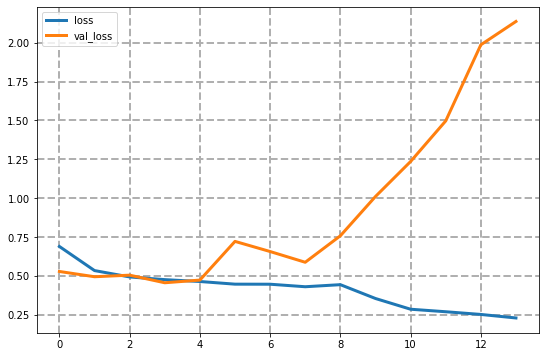

In [ ]:
#plot model training loss
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


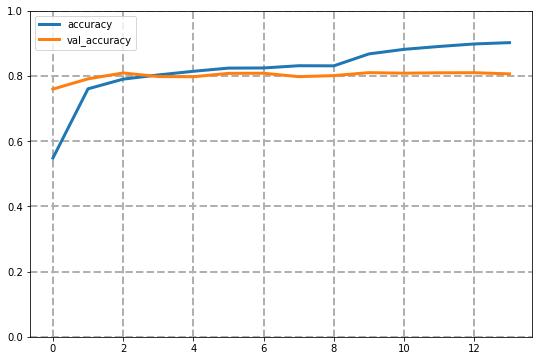

In [ ]:
#plot model training accuracy
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(train_padded_sequences, train_labels_encoded, verbose = 0)
valid_set_eval = model.evaluate(valid_padded_sequences, valid_labels_encoded, verbose = 0)

print(f'Training Set Evaluation:\n\tLoss: {round(train_set_eval[0],4)}\tAccuracy: {100*round(train_set_eval[1],4)}%')
print(f'Training Set Evaluation:\n\tLoss: {round(valid_set_eval[0],4)}\tAccuracy: {100*round(valid_set_eval[1],4)}%')


Training Set Evaluation:
	Loss: 0.387	Accuracy: 83.38%
Training Set Evaluation:
	Loss: 0.4553	Accuracy: 79.79%


In [ ]:
#def prediction
def predict_text(#define input text and model
                 input_text, tokenizer, model, 
                 #define tokenizer maximum length of sequence
                 maxlen_seq, padding = 'post', truncating = 'post'
                 ):
    
    #prediction
    text = str(input_text)
    sequence = tokenizer.texts_to_sequences([text])
    sequence = keras.preprocessing.sequence.pad_sequences(sequence, maxlen = maxlen_seq,
                                                          padding = padding, truncating = truncating)
    predict = model.predict(sequence)
    
    return predict


In [ ]:
#positive prediction
predict_text(#define input text and model
             input_text = 'It Was Really Good And Interesting', tokenizer = tokenizer, model = model,
             #define tokenizer maximum length of sequence
             maxlen_seq = 75, padding = 'post', truncating = 'post')


array([[0.93713933]], dtype=float32)

In [ ]:
#negative prediction
predict_text(#define input text and model
             input_text = 'It Was So Awful And Boring', tokenizer = tokenizer, model = model,
             #define tokenizer maximum length of sequence
             maxlen_seq = 75, padding = 'post', truncating = 'post')


array([[0.02241474]], dtype=float32)

In [ ]:
#save model
model.save('/content/model.h5')
